In [ ]:
import matplotlib.font_manager as fm
!apt-get update -qq 
!apt-get install fonts-nanum* -qq
fm._rebuild()

Selecting previously unselected package fonts-nanum.
(Reading database ... 155013 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [ ]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git 
% cd Mecab-ko-for-Google-Colab 
! bash install_mecab-ko_on_colab190912.sh
! pip install kss
! pip install umap-learn
! pip install hdbscan
! pip install glove-python-binary
! pip install pynndescent

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 312 kB/s 
     |████████████████████████████████| 448 kB 78.8 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-10-01 05:08:20--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00

In [ ]:
import os, sys 
from google.colab import drive 
drive.mount('/content/drive')
my_path = '/content/notebooks' 
os.symlink('/content/drive/My Drive/Colab Notebooks/env', my_path) 
sys.path.insert(0,my_path) 

Mounted at /content/drive


In [ ]:
import kss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import Mecab
from glove import Glove
from glove.corpus import Corpus

from sklearn.metrics.pairwise import cosine_similarity
from ctfidf import CTFIDFVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import scipy.sparse as sp
from sklearn.preprocessing import normalize
import networkx as nx
import re

import umap
import hdbscan

# 뉴스기사 로드

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/제주news_text.csv')

In [ ]:
df=df[['text']]

# 문장 토큰화

In [ ]:
en=['’','‘','“','”','"']
for i in df.index:
    for y in en:
        df.loc[i,'text']=df.loc[i,'text'].replace(y,' ')

In [ ]:
df['sent']=[kss.split_sentences((df.loc[i,'text']),use_heuristic=False) for i in df.index]

IndexError: ignored

In [ ]:
df

# 단어 토큰화 및 전처리

In [ ]:
stopwords=list(pd.read_table('/content/drive/MyDrive/한국어불용어100.txt')['word'])+['제주','제주도','이번']

In [ ]:
mecab=Mecab()

In [ ]:
def word_token(sents):
    return [mecab.morphs(sent) for sent in sents]
def proce(sent):
    sent=[re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣\s]','',word) for word in sent]
    return [word for word in sent if word not in stopwords and word and len(word)>1]
def proce_sent(sents):
    return [proce(sent) for sent in sents]

In [ ]:
df['token']=df['sent'].apply(word_token)

In [ ]:
df['token']=df['token'].apply(proce_sent)

# 전체 문장에 대한 임베딩을 위한 리스트

In [ ]:
token_list=[]
for i in df.token:
    for y in i:
        token_list.append(y)

In [ ]:
len(token_list)

200051

# Glove를 이용한 임베딩

In [ ]:
corpus=Corpus()

In [ ]:
corpus.fit(token_list,window=15)

In [ ]:
glove=Glove(no_components=512,learning_rate=0.05)
glove.fit(corpus.matrix,epochs=20,no_threads=4,verbose=False)
glove.add_dictionary(corpus.dictionary)
glove.save('/content/drive/MyDrive/Colab Notebooks/model/glove_512.model')

In [ ]:
glove=Glove.load('/content/drive/MyDrive/Colab Notebooks/model/glove_512.model')

In [ ]:
# 뉴스기사 문서별 임베딩을 위한 과정
glove_dict={}
for word in glove.dictionary.keys():
    glove_dict[word]=glove.word_vectors[glove.dictionary[word]]

# 전체 문장에 대한 임베딩을 통한 문서(뉴스기사)별 임베딩 추출

In [ ]:
zero_vector=np.zeros(512)

In [ ]:
def sent_vector(sent):
    if len(sent) != 0:
        return sum([glove_dict.get(w,zero_vector) for w in sent])/len(sent)
    else:
        return zero_vector

In [ ]:
def sent_to_vector(sents):
    return [sent_vector(sent) for sent in sents]

In [ ]:
df['Embedding']=df['token'].apply(sent_to_vector)
df[['Embedding']]

,Embedding
0,"[[-0.03917851899646468, 0.07791928410628489, -..."
1,"[[-0.022907759166309685, -0.05160816639117848,..."
2,"[[-0.054346935477408334, 0.10214318196550098, ..."
3,"[[-0.015595817972733137, 0.11495512544013649, ..."
4,"[[-0.04943396236930185, 0.10484670998233465, -..."
...,...
23142,"[[0.0062679341952386475, -0.013216670011472625..."
23143,"[[-0.013131623344004459, 0.07365225113867638, ..."
23144,"[[0.0009202567219550489, -0.042311457191311415..."
23145,"[[-0.04787815123672666, 0.059650855093904054, ..."


# 문장 벡터의 코사인 유사도 행렬

In [ ]:
def similarity(sent_embedding):
    matrix=np.zeros([len(sent_embedding),len(sent_embedding)])
    for i in range(len(sent_embedding)):
        for j in range(len(sent_embedding)):
            matrix[i][j]=cosine_similarity(sent_embedding[i].reshape(1,512),
                                           sent_embedding[j].reshape(1,512))[0,0]
    return matrix

In [ ]:
df['SimMatrix']=df['Embedding'].apply(similarity)
df[['SimMatrix']]

KeyboardInterrupt: ignored

# PageRank 알고리즘을 이용하여 각 문장별 score 산출

In [ ]:
def sim_score(matrix):
    nx_graph=nx.from_numpy_array(matrix)
    scores = nx.pagerank_numpy(nx_graph,)
    return scores

In [ ]:
df['score']=df['SimMatrix'].apply(sim_score)
df[['SimMatrix','score']]

# 가장 상위의 점수를 갖는 문장 n개만을 반환 (추출할 요약문)

In [ ]:
def ranked_sents(sents,scores,n=3):
    top_scores=sorted(((scores[i],s)
    for i,s in enumerate(sents)),reverse=True)
    top_n_sents=[sent for score,sent in top_scores[:n]]
    return " ".join(top_n_sents)

In [ ]:
df['summary']=df.apply(lambda x: ranked_sents(x.sent, x.score),axis=1)

In [ ]:
for i in range(10):
    print(i+1,'번 뉴스')
    print('원문 :',df.loc[i].text,'\n')
    print('요약 :',df.loc[i].summary,'\n')

In [ ]:
df.to_csv('/content/drive/MyDrive/뉴스_추출.csv',encoding='utf-8',index=False)

# 추출한 요약문의 토픽모델링

In [ ]:
print(df.loc[10,'text'])
print(df.loc[10,'token'])
print(df.loc[10,'Embedding'])
print(df.loc[10,'SimMatrix'])
print(df.loc[10,'score'])
print(df.loc[10,'summary'])

한라산 관리사업 균형발전사업 우수사례 선정 제주도가 추진 중인  자연환경보전 및 관리(한라산국립공원관리)  사업이 균형발전사업 우수사례로 최종 선정되는 영예를 안았다. 제주특별자치도는 대통령직속 국가균형발전위원회에서 주관하는  2021년도 균형발전사업 평가 에서 이 같은 성과를 거뒀다고 19일 밝혔다. 국가균형발전위원회는국가균형발전특별법에 따라 매년 국가균형발전특별회계로 지원되는 사업에 대해 실적을 평가하고 있다. 지난해 우수등급을 받은 사업을 대상으로 서면평가 및 전문가 현장실사를 진행한 결과, 전국적으로 18개 사업이 우수사례로 선정됐다. 한라산국립공원사무소에서 시행한  자연환경 보전 및 관리  사업은 한라산국립공원 지정 50주년을 맞아 탐방객의 자발적 환경보호 동참을 이끌면서 올바른 탐방문화 정착에 기여했다는 평가를 받았다. 특히국제 4대 보호지역(유네스코 생물권보전지역, 유네스코 세계자연유산, 유네스코 세계지질공원, 람사르습지 보전지역)에 걸맞게 보호 관리함으로써 자연환경 보전의 모범을 보였다는 평가를 받았다. 한라산국립공원사무소는 이 사업을 통해 무방류 순환 수세식 화장실 7개소를 전면 교체해 최상류 지역의 지하수 자원보전 및 자연환경과 조화되는 쾌적한 탐방환경을 조성했다. 또한 국내 최초로 한라산 탐방 사전예약제를 실시해 △코로나19 예방 △5·16도로 불법주차 해소 △안전사고 발생 저감 △쓰레기 발생 감소 등 쾌적한 산행문화를 정착시켰다. 시상식은 오는 10월 말 경북 안동시에서 열리는 2021 균형발전박람회에서 진행되며, 해당 지자체 및 담당자에게는 국가균형발전위원회 위원장 명의의 상장 등이 주어진다. 이와 함께발전위가 발간하는 우수사례집에 실려 타 지자체의 벤치마킹 등의 자료로 활용된다. 
[['한라산', '관리', '사업', '균형발전', '사업', '우수', '사례', '선정', '추진', '자연환경', '보전', '관리', '한라산', '국립', '공원', '관리', '사업', '균형발전', '사업', '우수', '사례', '최종', '선

In [ ]:
### 저장한 파일,모델 로드

df=pd.read_csv('/content/drive/MyDrive/뉴스_추출.csv')
news=df.summary.values
text_list=[]
mecab=Mecab()
for i in news:
    text=mecab.nouns(i)
    txt=[]
    for y in text:
        if len(y)>1 and y not in stopwords:
            txt.append(y)
    text_list.append(txt)
    
glove=Glove.load('/content/drive/MyDrive/Colab Notebooks/model/glove_512.model')
glove_dict={}
for word in glove.dictionary.keys():
    glove_dict[word]=glove.word_vectors[glove.dictionary[word]]

zero_vector=np.zeros(512)
def sent_vector(sent):
    if len(sent) != 0:
        return sum([glove_dict.get(w,zero_vector) for w in sent])/len(sent)
    else:
        return zero_vector
def sent_to_vector(sents):
    return [sent_vector(sent) for sent in sents]

def word_vector(word):
    if len(word) != 0:
        return [glove_dict.get(w,zero_vector) for w in word]
    else:
        return zero_vector
def word_to_vector(words):
    return [word_vector(word) for word in words]

In [ ]:
word_glove=word_to_vector(text_list)

In [ ]:
sent_glove=sent_to_vector(text_list)

In [ ]:
sent_glove=np.array(sent_glove)
word_glove=np.array(word_glove)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
print(sent_glove.shape,word_glove.shape)

(23147, 512) (23147,)


In [ ]:
def mmr(sents_embed, words_embed, words, n, diversity):

    senword_similar = cosine_similarity(words_embed, sents_embed)
    word_similar = cosine_similarity(words_embed)

    keywords_idx = [np.argmax(senword_similar)]
    text_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    if len(words) >= 5:
        for _ in range(n - 1):
            text_similar = senword_similar[text_idx, :]
            target_similar = np.max(word_similar[text_idx][:, keywords_idx], axis=1)

            mmr = (1-diversity) * text_similar - diversity * target_similar.reshape(-1, 1)
            mmr_idx = text_idx[np.argmax(mmr)]

            keywords_idx.append(mmr_idx)
            text_idx.remove(mmr_idx)
    else:
        for _ in range(len(words) - 1):
            text_similar = senword_similar[text_idx, :]
            target_similar = np.max(word_similar[text_idx][:, keywords_idx], axis=1)

            mmr = (1-diversity) * text_similar - diversity * target_similar.reshape(-1, 1)
            mmr_idx = text_idx[np.argmax(mmr)]

            keywords_idx.append(mmr_idx)
            text_idx.remove(mmr_idx)

    return [words[idx] for idx in keywords_idx]

In [ ]:
n = 5
mmr_words=[]
for i in range(sent_glove.shape[0]):
    mmr_words.append(mmr(sent_glove[i].reshape(1,-1),np.array(word_glove[i]),text_list[i],n=n,diversity=0.5))

In [ ]:
len(mmr_words)

23147

In [ ]:
mmr_words[10]

['사업', '국립', '우수', '관리', '국가']

# UMAP, HDBSAN을 이용한 차원축소, 클러스터링 및 시각화

In [ ]:
umap_embeddings=umap.UMAP(n_neighbors=20,n_components=5,metric='cosine').fit_transform(sent_glove)

/content/notebooks/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
label = hdbscan.HDBSCAN(min_cluster_size=20,metric='euclidean',cluster_selection_method='eom').fit(umap_embeddings)

In [ ]:
label.labels_

array([ -1, 112,  94, ...,  97,  -1,  -1])

In [ ]:
umap_data=umap.UMAP(n_neighbors=20,n_components=2,min_dist=0.0,metric='cosine').fit_transform(sent_glove)
result=pd.DataFrame(umap_data, columns=['x','y'])
result['labels']=label.labels_
result

,x,y,labels
0,-1.462844,2.192425,-1
1,-0.021028,9.669397,112
2,-1.927857,9.305455,94
3,6.142665,3.120595,3
4,2.700885,4.705083,30
...,...,...,...
23142,2.777398,12.249786,28
23143,-1.684785,7.288200,93
23144,0.377740,8.372076,97
23145,0.549969,11.885906,-1


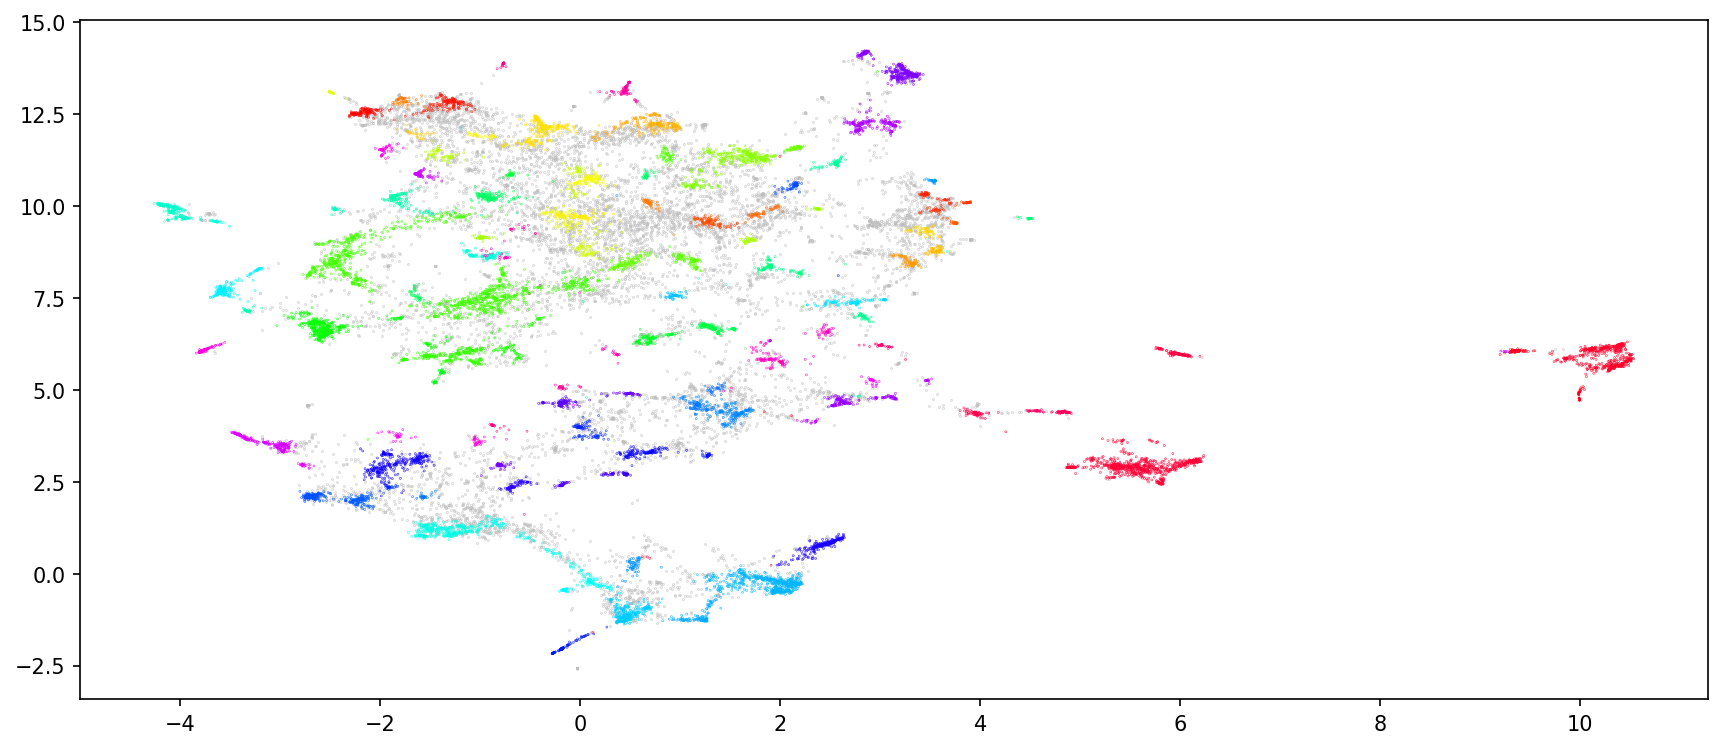

In [ ]:
fig,ax=plt.subplots(figsize=(14,6),dpi=150)
outliers=result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels,s=0.05,cmap='hsv_r')
plt.savefig('/content/drive/MyDrive/cluster.jpg')
plt.show()

# 군집별 토픽분류

In [ ]:
text_set=[]
text_set=[' '.join(i) for i in mmr_words]

In [ ]:
data=pd.DataFrame(text_set).rename(columns={0:'doc'})
data['Topic']=label.labels_
data['doc_id']=range(len(data))

In [ ]:
data

,doc,Topic,doc_id
0,사건 진행 교사 경찰 관련,-1,0
1,연구 모델 흐름 지하수 필요,112,1
2,평화 건강 행사 미래 행복,94,2
3,확진 생활 지역 사례 치료,3,3
4,이후 허용 거리 완료 가능,30,4
...,...,...,...
23142,이벤트 중문 행사 선정 주년,28,23142
23143,의회 비난 처리 허가 찬성,93,23143
23144,추진 공사 발전 수익 이전,97,23144
23145,행사 공항 지역 문화 예정,-1,23145


# 클래스기반 TF-IDF를 위한 군집별 각 문서의 단일 클래스화

In [ ]:
topic=data.groupby(['Topic'],as_index=False).agg({'doc':' '.join})

In [ ]:
topic['Topic']=topic.index

In [ ]:
topic

,Topic,doc
0,0,사건 진행 교사 경찰 관련 대학교 온라인 과정 이날 예정 은행 상품 보험 대상 기념...
1,1,속도 운전자 도로 평균 적발 도로 오전 지역 기록 차량 도로 차량 안전 자치 기준 ...
2,2,태풍 일본 전망 해상 기상청 태풍 지역 항공편 기록 오전 태풍 영향 오후 피해 내륙...
3,3,오후 올해 전망 다음 기상청 기온 조사 시기 가운데 평균 바람 지역 당부 오후 이상...
4,4,확진 생활 지역 사례 치료 확진 지역 현재 코로나 확인 확진 지역 도내 기준 동안 ...
...,...,...
130,130,농협 주제 역량 참석 농업 간담회 농협 지역 서귀포시 의원 농협 기여 농업 지원 조...
131,131,농협 평가 대상 축협 금융 농협 감사 방역 직원 기간 농협 선정 공헌 전국 수상 본...
132,132,봉사 농협 지역 환경 지속 봉사 회장 지역 전달 지원 활동 거주 환경 복지 지역 환...
133,133,지원 전달 관내 복지 적십자사 계층 참여 지역 활동 지원 전달 회장 지역 농협 지원...


# C-TF-IDF 수행

In [ ]:
count_vectorizer=CountVectorizer().fit(topic.doc)
count=count_vectorizer.transform(topic.doc)
words=count_vectorizer.get_feature_names()

ctfidf=CTFIDFVectorizer().fit_transform(count,n_samples=len(data)).toarray()
words_per_topic = {label: [words[index] 
                for index in ctfidf[label].argsort()[-20:]] 
                   for label in topic.Topic}
txt_list=[]
for i in words_per_topic.values():
    txt=[]
    for y in i:
        txt.append(y)
    txt_list.append(txt)
txt_set=[' '.join(i) for i in txt_list]
words_per_df=pd.DataFrame({'Topic':words_per_topic.keys(),'doc':txt_set})

In [ ]:
words_per_topic

{0: ['확대',
  '활용',
  '협력',
  '사랑',
  '장애',
  '업무',
  '복지',
  '감귤',
  '기술',
  '전달',
  '청소년',
  '정보',
  '봉사',
  '선정',
  '우수',
  '여성',
  '협약',
  '산업',
  '경제',
  '농업'],
 1: ['창원',
  '분기점',
  '투입',
  '운행',
  '곳곳',
  '차량',
  '기상',
  '상황',
  '교통',
  '속도',
  '산록',
  '당부',
  '교차로',
  '입구',
  '정상',
  '대형',
  '도로',
  '구간',
  '통제',
  '소형'],
 2: ['접근',
  '바람',
  '내일',
  '북쪽',
  '동반',
  '발효',
  '전역',
  '우리나라',
  '남부',
  '예상',
  '최대',
  '이동',
  '기상청',
  '중심',
  '부근',
  '해상',
  '영향',
  '일본',
  '전망',
  '태풍'],
 3: ['북부',
  '아침',
  '해상',
  '고기압',
  '주의',
  '도로',
  '바람',
  '내일',
  '위치',
  '구름',
  '예상',
  '산간',
  '남쪽',
  '바다',
  '영향',
  '최고',
  '날씨',
  '기온',
  '전망',
  '기상청'],
 4: ['조치',
  '방역',
  '보건',
  '환자',
  '자치도',
  '바이러스',
  '코로나',
  '파악',
  '방문',
  '추가',
  '확인',
  '진단',
  '역학',
  '감염',
  '메르스',
  '판정',
  '현재',
  '격리',
  '검사',
  '확진'],
 5: ['항공편',
  '대한항공',
  '인천',
  '체류',
  '속출',
  '태풍',
  '발효',
  '한국공항공사',
  '중단',
  '도착',
  '국제공항',
  '공항',
  '강풍',
  '지연',
  '재개',
  '결항',
  '출발',
  '노선',
  '운항',
  '

In [ ]:
topic

,Topic,doc
0,0,사건 진행 교사 경찰 관련 대학교 온라인 과정 이날 예정 은행 상품 보험 대상 기념...
1,1,속도 운전자 도로 평균 적발 도로 오전 지역 기록 차량 도로 차량 안전 자치 기준 ...
2,2,태풍 일본 전망 해상 기상청 태풍 지역 항공편 기록 오전 태풍 영향 오후 피해 내륙...
3,3,오후 올해 전망 다음 기상청 기온 조사 시기 가운데 평균 바람 지역 당부 오후 이상...
4,4,확진 생활 지역 사례 치료 확진 지역 현재 코로나 확인 확진 지역 도내 기준 동안 ...
...,...,...
130,130,농협 주제 역량 참석 농업 간담회 농협 지역 서귀포시 의원 농협 기여 농업 지원 조...
131,131,농협 평가 대상 축협 금융 농협 감사 방역 직원 기간 농협 선정 공헌 전국 수상 본...
132,132,봉사 농협 지역 환경 지속 봉사 회장 지역 전달 지원 활동 거주 환경 복지 지역 환...
133,133,지원 전달 관내 복지 적십자사 계층 참여 지역 활동 지원 전달 회장 지역 농협 지원...


# C-TF-IDF의 비교를 통한 토픽 병합_축소

In [ ]:
size=[]
for i in range(10):
    distances = cosine_similarity(ctfidf, ctfidf)
    np.fill_diagonal(distances, 0)

    merge_topic=[(topic.Topic[index], topic.Topic[distances[index].argmax()]) 
                            for index in range(len(topic))]
    topic['Topic']=[merge_topic[i][1] for i in topic.index]

    size.append(topic.groupby(['Topic'])
                        .doc
                        .count()
                        .reset_index()
                        .rename(columns={'doc':'size'})
                        .sort_values("size", ascending=False))

    topic=topic.groupby(['Topic'],as_index=False).agg({'doc':' '.join})

    count_vectorizer=CountVectorizer().fit(topic.doc)
    count=count_vectorizer.transform(topic.doc)
    words=count_vectorizer.get_feature_names()

    ctfidf=CTFIDFVectorizer().fit_transform(count,n_samples=len(data)).toarray()

f_per_topic = {topic.Topic[label]: [words[index] 
                for index in ctfidf[label].argsort()[-20:]] 
                   for label in topic.index}
txt_list=[]
for i in f_per_topic.values():
    txt=[]
    for y in i:
        txt.append(y)
    txt_list.append(txt)
txt_set=[' '.join(i) for i in txt_list]
f_per_df=pd.DataFrame({'Topic':f_per_topic.keys(),'doc':txt_set})

In [ ]:
size

[    Topic  size
 0       0    25
 72    127     4
 35     62     3
 73    128     3
 64    111     3
 ..    ...   ...
 40     69     1
 42     75     1
 44     79     1
 45     80     1
 43     76     1
 
 [77 rows x 2 columns],     Topic  size
 59    127     6
 58    125     3
 40     85     3
 0       0     2
 14     31     2
 ..    ...   ...
 30     56     1
 1       2     1
 32     61     1
 33     62     1
 31     60     1
 
 [62 rows x 2 columns],     Topic  size
 57    127     2
 34     67     2
 0       0     1
 44     90     1
 32     62     1
 33     63     1
 35     68     1
 36     74     1
 37     75     1
 38     80     1
 39     85     1
 40     86     1
 41     87     1
 42     88     1
 43     89     1
 45     91     1
 1       2     1
 46     93     1
 47     94     1
 48    102     1
 49    106     1
 50    108     1
 51    111     1
 52    112     1
 53    114     1
 54    115     1
 55    117     1
 56    122     1
 58    129     1
 31     61     1
 30     60     

In [ ]:
f_per_topic

{0: ['협약',
  '운영',
  '추진',
  '한편',
  '안전',
  '관광',
  '복지',
  '여성',
  '경제',
  '대상',
  '교육',
  '행사',
  '참여',
  '활동',
  '산업',
  '개최',
  '농업',
  '문화',
  '농협',
  '기업'],
 2: ['동반',
  '바람',
  '내일',
  '오후',
  '우리나라',
  '발효',
  '전역',
  '남부',
  '오전',
  '예상',
  '이동',
  '최대',
  '부근',
  '중심',
  '기상청',
  '영향',
  '일본',
  '해상',
  '전망',
  '태풍'],
 7: ['하루',
  '가능',
  '필요',
  '가운데',
  '이상',
  '누적',
  '집계',
  '이후',
  '대상',
  '기관',
  '포함',
  '시설',
  '현재',
  '종사자',
  '전국',
  '예약',
  '코로나',
  '백신',
  '기준',
  '접종'],
 8: ['어르신',
  '부담',
  '주의보',
  '기관',
  '확인',
  '국가',
  '수칙',
  '감염증',
  '보건',
  '등록',
  '어린이',
  '실시',
  '의료',
  '지정',
  '폐렴',
  '이상',
  '예방',
  '무료',
  '보건소',
  '접종'],
 9: ['오후',
  '고산',
  '심정지',
  '가축',
  '당부',
  '올해',
  '절정',
  '정상',
  '내년',
  '통제',
  '야간',
  '지정',
  '입산',
  '대피소',
  '관리',
  '연장',
  '조정',
  '공원',
  '코스',
  '한라산'],
 12: ['관리',
  '소장',
  '장관',
  '기여',
  '위원',
  '일자',
  '기획',
  '총괄',
  '선거관리위원회',
  '팀장',
  '행정',
  '지도',
  '선관위',
  '우체국',
  '도선',
  '신임',
  '사무',
  '인사',
  '과장',
  '

In [ ]:
for i in f_per_df.index:
    print(f_per_df.loc[i,'Topic'])

0
2
7
8
9
12
16
21
24
25
27
28
29
30
31
32
33
35
38
39
40
41
42
46
50
51
52
53
55
56
60
61
62
63
67
68
74
75
80
85
86
87
88
89
90
91
93
94
102
106
108
111
112
114
115
117
122
127
129
133
